**Encoder-Decoder Sequence to Sequence Model**

  การสร้าง Encoder-Decoder Sequence to Sequence Model โดยใช้ recurrent neural networks (RNNs) ตัวที่เหมาะสม คือ LSTM หรือ GRU

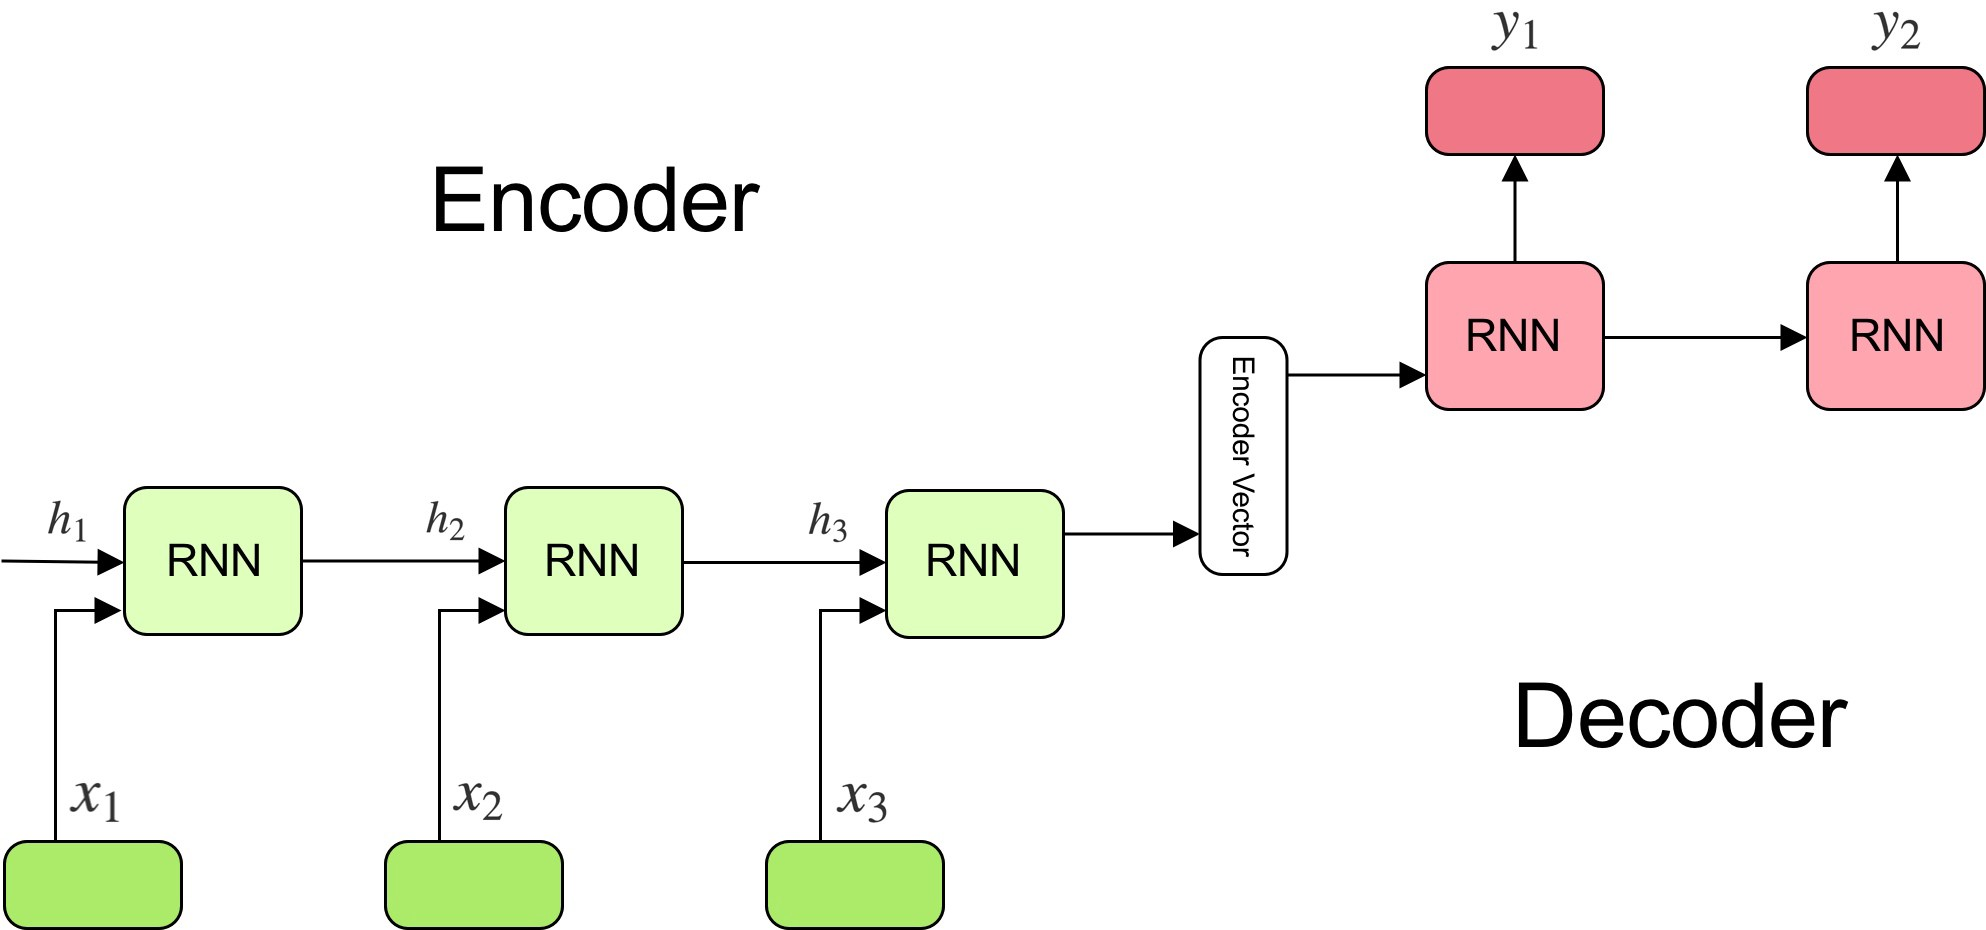

**Training model**

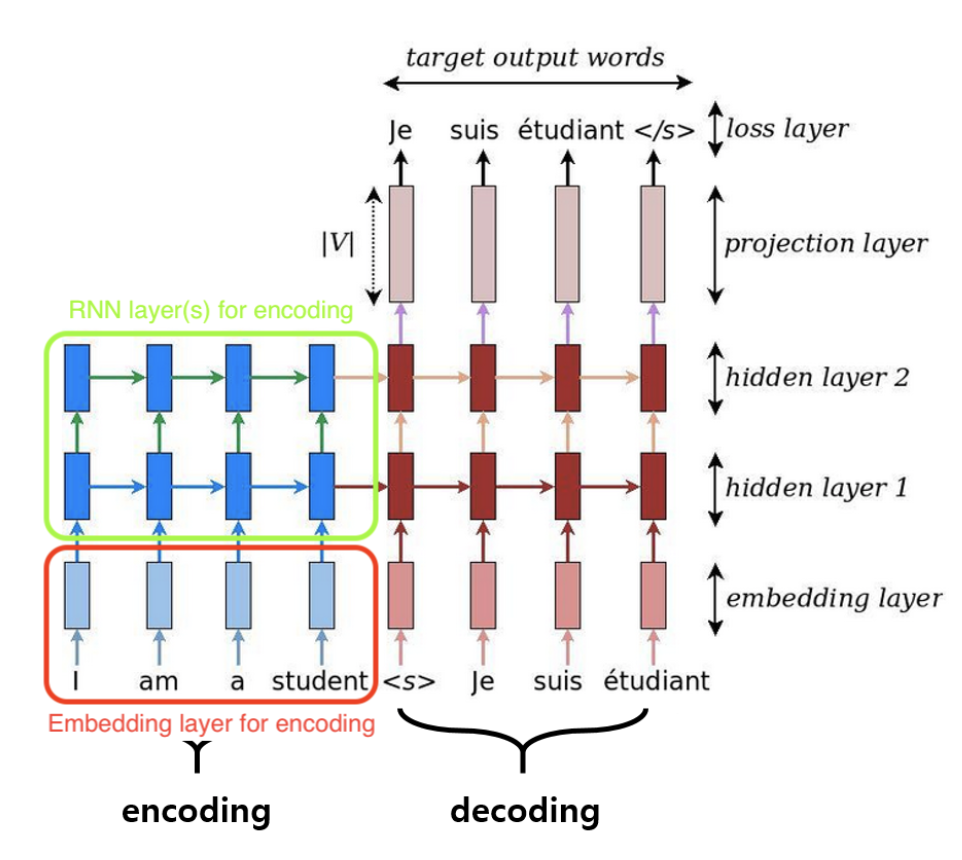

องค์ประกอบแบ่งเป็น 3 ส่วน คือ
1.   Encoder
2.   Encoder Vector
3.   Decoder


**Encoder**

> Hidden states h_i ถูกคำนวณด้วยสมการ:



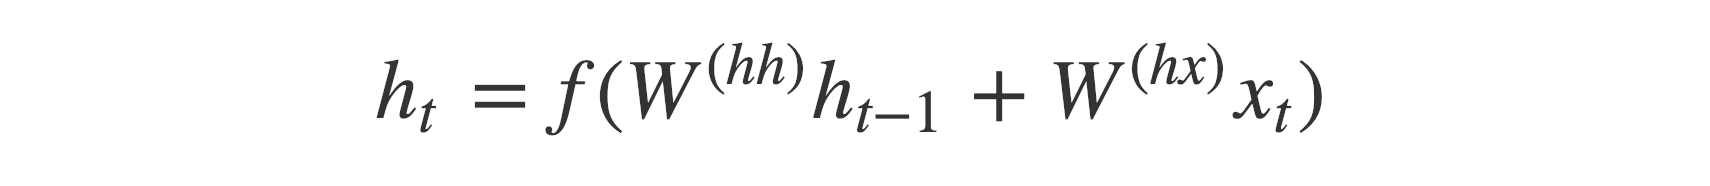

**Encoder Vector**

> มันคือการทำ initial input ในของส่วน Decoder



**Decoder**

> จาก output y_i หรือ output ของส่วน Encoder จะถูกส่งต่อมาเป็น input ของส่วน Decoder

> และ hidden state h_i จะใช้สมการ:





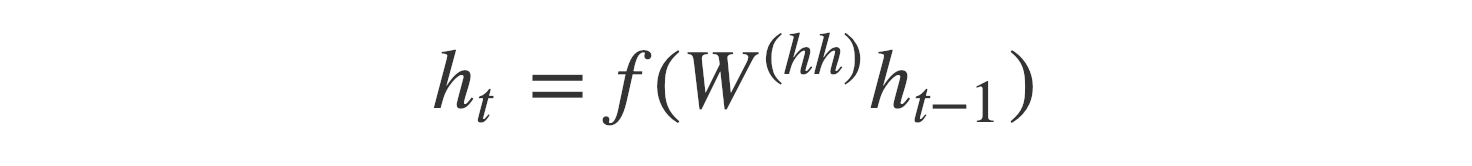



> แล้วคำนวณ output y_t หรือ output ส่วนของ Decoder ด้วยสมการ :



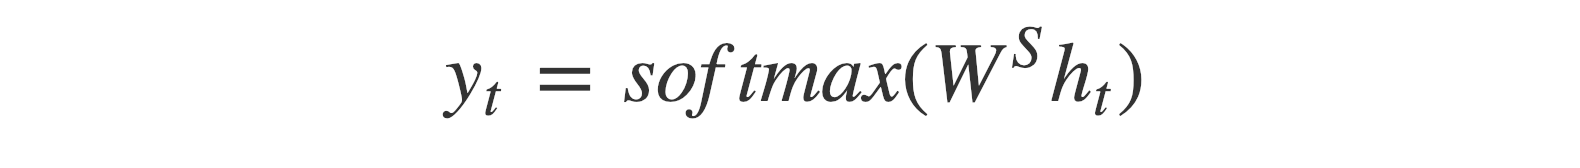

---

**ตัวอย่าง การสร้างโมเดล**

> การใช้ LSTM แปลภาษาจาก ภาษาอังกฤษ เป็น ภาษาฝรั่งเศษ



In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 5  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()




Using TensorFlow backend.


In [0]:
import pandas as pd 
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [3]:
file_list = drive.ListFile({'q': "'14uoeJJZvJYKKb3dc1K56hLi27pBc8Av5' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: สำเนาของ eng to fre.ipynb, id: 1kdfXNDMxDjFRCogVSGPyWbJ8jz-ANvpo
title: eng to fre.ipynb, id: 1J3t6R0ArcAjD64PQ4aP7JwBzfNER7g4L
title: fra2.txt, id: 1isKhLwMTWfKnT1v0OfZ-BX4eQi8tlPlY
title: fra.txt, id: 1aRsF-xlzAH1oaWSsvZj7SacrMaVTT73Z


In [0]:
data_downloaded = drive.CreateFile({'id': '1aRsF-xlzAH1oaWSsvZj7SacrMaVTT73Z'})
data_downloaded.GetContentFile('fra.txt')

In [0]:
data_path = "/content/fra.txt"
with open(data_path, 'r', encoding='utf-8') as f:
     lines = f.read().split('\n')


In [6]:
lines

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)',
 'Hi.\tSalut.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)',
 'Run!\tCours\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)',
 'Run!\tCourez\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)',
 'Who?\tQui ?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)',
 'Wow!\tÇa alors\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)',
 'Fire!\tAu feu !\tCC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)',
 "Help!\tÀ l'aide\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)",
 'Jump.\tSaute.\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishi

In [0]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [10]:
target_characters

{'\t',
 '\n',
 ' ',
 '!',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '5',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '»',
 'À',
 'Ç',
 'É',
 'Ê',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ',
 '\u2009',
 '’',
 '\u202f'}

In [0]:
input_texts

['Go.',
 'Hi.',
 'Hi.',
 'Run!',
 'Run!',
 'Who?',
 'Wow!',
 'Fire!',
 'Help!',
 'Jump.',
 'Stop!',
 'Stop!',
 'Stop!',
 'Wait!',
 'Wait!',
 'Go on.',
 'Go on.',
 'Go on.',
 'Hello!',
 'Hello!',
 'I see.',
 'I try.',
 'I won!',
 'I won!',
 'I won.',
 'Oh no!',
 'Attack!',
 'Attack!',
 'Cheers!',
 'Cheers!',
 'Cheers!',
 'Cheers!',
 'Get up.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Got it!',
 'Got it!',
 'Got it?',
 'Got it?',
 'Got it?',
 'Hop in.',
 'Hop in.',
 'Hug me.',
 'Hug me.',
 'I fell.',
 'I fell.',
 'I know.',
 'I left.',
 'I left.',
 'I lost.',
 'I paid.',
 "I'm 19.",
 "I'm OK.",
 "I'm OK.",
 'Listen.',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'Really?',
 'Really?',
 'Really?',
 'Thanks.',
 'We try.',
 'We won.',
 'We won.',
 'We won.',
 'We won.',
 'Ask Tom.',
 'Awesome!',
 'Be calm.',
 'Be calm.',
 'Be calm.',
 'Be cool.',
 'Be fair.',
 'Be fair.',
 'Be fair.',
 'Be fair.',
 'Be fair.',
 'Be fair.',
 'Be ki

In [0]:
target_texts

['\tVa !\n',
 '\tSalut !\n',
 '\tSalut.\n',
 '\tCours\u202f!\n',
 '\tCourez\u202f!\n',
 '\tQui ?\n',
 '\tÇa alors\u202f!\n',
 '\tAu feu !\n',
 "\tÀ l'aide\u202f!\n",
 '\tSaute.\n',
 '\tÇa suffit\u202f!\n',
 '\tStop\u202f!\n',
 '\tArrête-toi !\n',
 '\tAttends !\n',
 '\tAttendez !\n',
 '\tPoursuis.\n',
 '\tContinuez.\n',
 '\tPoursuivez.\n',
 '\tBonjour !\n',
 '\tSalut !\n',
 '\tJe comprends.\n',
 "\tJ'essaye.\n",
 "\tJ'ai gagné !\n",
 "\tJe l'ai emporté !\n",
 '\tJ’ai gagné.\n',
 '\tOh non !\n',
 '\tAttaque !\n',
 '\tAttaquez !\n',
 '\tSanté !\n',
 '\tÀ votre santé !\n',
 '\tMerci !\n',
 '\tTchin-tchin !\n',
 '\tLève-toi.\n',
 '\tVa, maintenant.\n',
 '\tAllez-y maintenant.\n',
 '\tVas-y maintenant.\n',
 "\tJ'ai pigé !\n",
 '\tCompris !\n',
 '\tPigé\u202f?\n',
 '\tCompris\u202f?\n',
 "\tT'as capté\u202f?\n",
 '\tMonte.\n',
 '\tMontez.\n',
 '\tSerre-moi dans tes bras !\n',
 '\tSerrez-moi dans vos bras !\n',
 '\tJe suis tombée.\n',
 '\tJe suis tombé.\n',
 '\tJe sais.\n',
 '\tJe suis parti.\

In [11]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [0]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


In [0]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):

    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [0]:
# #encoder_input_data[i][j][k]
# i = ตำแหน่ง row ของ dataset
# j = ตำแหน่ง ตัวอักษร ในประโยค max = 16
# k = ตำแหน่ง onehot index ของ ตัวอักษร จาก dict

In [0]:
# input[][][]

# [
#  ตัวอย่าง Go.
#  [ G=> [0,0,0,... จำนวน = 70],
#    o=> [0,0,0,... จำนวน = 70],
#    .=> [0,0,0,... จำนวน = 70],
#    _=> [0,0,0,... จำนวน = 70],
#    _=> [0,0,0,... จำนวน = 70],
#    _=> [0,0,0,... จำนวน = 70],
#     .
#     .
#     .
#     จำนวน = 16
#  ],...จำนวน = 10,000
# ]

In [15]:

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [17]:
epochs = 1
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')



# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())




Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 68s 9ms/step - loss: 0.8441 - acc: 0.7733 - val_loss: 0.8286 - val_acc: 0.7684


In [18]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 70)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 334848      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [0]:
# test input = คำแรกจำนวน x แรกใน train data ## range(x)

In [21]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)
    

-
Input sentence: Go.
Decoded sentence: Tous s                                                      
-
Input sentence: Hi.
Decoded sentence: Tous s                                                      
-
Input sentence: Hi.
Decoded sentence: Tous s                                                      
-
Input sentence: Run!
Decoded sentence: Tous s                                                      
-
Input sentence: Run!
Decoded sentence: Tous s                                                      
-
Input sentence: Who?
Decoded sentence: Tous s                                                      
-
Input sentence: Wow!
Decoded sentence: Tous s                                                      
-
Input sentence: Fire!
Decoded sentence: Tous s                                                      
-
Input sentence: Help!
Decoded sentence: Tous s                                                      
-
Input sentence: Jump.
Decoded sentence: Tous s                                   